In [1]:
# proxy
import os
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import models
from torchvision import transforms, utils

In [3]:
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from io import BytesIO
import IPython.display as display

In [4]:
# util
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    Image.fromarray(a).save(f, fmt)
    display.display(display.Image(data=f.getvalue()))
    
    
def showtensor(a):
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    inp = a[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255
    showarray(inp)
    display.clear_output(wait=True)

## Loading DNN model

In [5]:
device = torch.device('cuda')
net = models.vgg16(pretrained=True)
# net = nn.DataParallel(net)
net = net.to(device)
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## Producing dreams

In [16]:
def objective_L2(dst, guide_features):
    return dst.data

def make_step(model, img, step_size=1.5, learning_rate=4e-1, end_layer=28, jitter=32, control=None, objective=objective_L2):
    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])
    
    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    img = np.roll(np.roll(img, ox, -1), oy, -2)
    img_tensor = torch.Tensor(img)
    img_variable = Variable(img_tensor.cuda(), requires_grad=True)
    
    model.zero_grad()
    
    x = img_variable
    for index, layer in enumerate(model.features.children()):
        x = layer(x)
        if index == end_layer:
            break
            
    diff_out = objective(x, control)
    x.backward(diff_out)
    
    mean_square = torch.Tensor([torch.mean(img_variable.grad.data ** 2)])
    mean_square = mean_square.cuda()
    img_variable.data.add_(img_variable.grad.data/torch.sqrt(mean_square)*step_size*learning_rate)
    
    img = img_variable.data.cpu().numpy()
    img = np.roll(np.roll(img, -ox, -1), -oy, -2)
    img[0, :, :, :] = np.clip(img[0, :, :, :], -mean/std, (1-mean)/std)
    
    showtensor(img)
    
    return img

    
def deepdream(model, base_img, iter_n=10, octave_n=6, octave_scale=1.4, 
              learning_rate=4e-1, end_layer=28, control=None, objective=objective_L2):
    octaves = [base_img]
    for i in range(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1.0/octave_scale, 1.0/octave_scale), order=1))
        
    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1, 1.0 * h / h1, 1.0 * w / w1), order=1)
            
        src = octave_base + detail
        for i in range(iter_n):
            out = make_step(model, src, learning_rate=4e-1, end_layer=end_layer, control=control, objective=objective)
        
        detail = out - octave_base
    
    return out

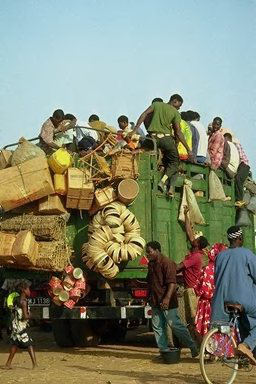

In [56]:
preprocess = transforms.Compose([
#     transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_img = Image.open('../../img/16024.jpg')
input_tensor = preprocess(input_img).unsqueeze(0)
input_np = input_tensor.numpy()
input_img

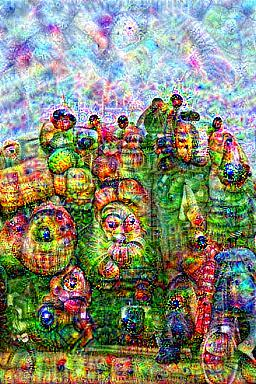

In [58]:
out = deepdream(net, input_np, iter_n=10, learning_rate=0.05, end_layer=24)

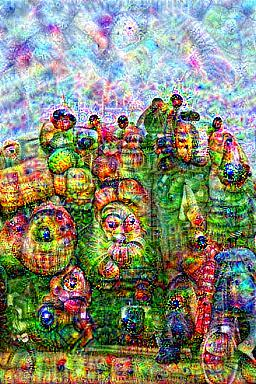

In [59]:
showtensor(out)

1. market: iter10 rate 8e-3 end24
1. flower: deepdream(net, input_np, iter_n=10, learning_rate=0.8, end_layer=24)
1. lion: out = deepdream(net, input_np, iter_n=30, learning_rate=0.5, end_layer=24)
1. trump: out = deepdream(net, input_np, iter_n=10, learning_rate=0.03, end_layer=25)
1. trac : out = deepdream(net, input_np, iter_n=10, learning_rate=0.05, end_layer=24)